# 6.4 Supervised Machine Learning: Regression
## This script contains the following:
1. Importing libraries and data
2. Data cleaning
3. Data prep for regression analysis
4. Define Hypothesis
5. Regression analysis
6. Result
7. Define New Hypothesis
8. New Result

### 01. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from geopy import distance
from math import sin, cos, sqrt, atan2, radians
from sklearn.neighbors import DistanceMetric

In [2]:
%matplotlib inline

In [3]:
# define path
path = r'/Users/sudip/Desktop/DATA ANALYST/Projects/Project 6/Data'

In [4]:
# import data
df = pd.read_csv(os.path.join(path, 'prepared_data', 'airbnb_berlin_cleaned_3.csv'))

### 02. Data Cleaning

In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'name', 'host_id', 'district',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'host_total_listings', 'availability_365',
       'num_reviews_ltm', 'price_category'],
      dtype='object')

In [6]:
#Removing 'Unnamed' column as it is irrelevant for analysis.
df = df.drop(columns= ["Unnamed: 0", "Unnamed: 0.1"], axis=1)

In [7]:
df.columns

Index(['id', 'name', 'host_id', 'district', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'host_total_listings', 'availability_365', 'num_reviews_ltm',
       'price_category'],
      dtype='object')

In [8]:
df.head()

,id,name,host_id,district,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,host_total_listings,availability_365,num_reviews_ltm,price_category
0,39971294,Cozy flat with chimney,21565256,Friedrichshain-Kreuzberg,nördliche Luisenstadt,52.50168,13.41573,Entire home/apt,50,1,2,2019-12-02,0.06,1,0,0,medium_price
1,11934470,Bright Studio Apartment / 4th fl/ long term,62819516,Neukölln,Reuterstraße,52.49226,13.42937,Entire home/apt,43,30,5,2022-03-29,0.07,2,271,3,medium_price
2,17580693,"Gemütliches, Zentrales Zimmer mit Blick ins Grüne",119416956,Mitte,Parkviertel,52.56151,13.35515,Private room,42,2,31,2022-03-07,0.50,1,10,4,medium_price
3,17497917,BERLIN MITTE - hotspot - central & calm,5937313,Mitte,Alexanderplatz,52.52438,13.41012,Entire home/apt,106,2,116,2022-05-29,1.84,1,6,25,high_price
4,9924899,"Charming room in Kreuzberg, Graefekiez",4289187,Friedrichshain-Kreuzberg,Tempelhofer Vorstadt,52.49087,13.41712,Private room,39,3,7,2019-09-20,0.09,2,0,0,medium_price


In [9]:
df.shape

(12869, 17)

#### Missing Values

In [10]:
# check for missing values
df.isnull().sum() # No Missing Values

id                     0
name                   0
host_id                0
district               0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
last_review            0
reviews_per_month      0
host_total_listings    0
availability_365       0
num_reviews_ltm        0
price_category         0
dtype: int64

#### Duplicate check

In [11]:
dups = df.duplicated()
dups.shape # No Dups

(12869,)

##### Extreme values checks

/Users/sudip/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

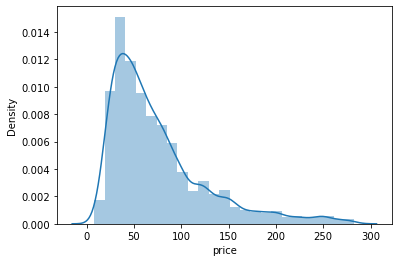

In [12]:
sns.distplot(df['price'], bins=25)  # Shows extreme values

In [13]:
df['price'].describe()

count    12869.000000
mean        75.015852
std         51.495651
min          8.000000
25%         39.000000
50%         60.000000
75%         95.000000
max        283.000000
Name: price, dtype: float64

### 3. Data prep for regression analysis 

In [14]:
# finding distance from centerof berlin for each listing
center_lat = float(52.5200) # center of berlin latitude
center_long = float(13.4050) # center of berlin longitude
listing_lat = df['latitude']
listing_long = df['longitude']

df['dist_from_center'] = (((center_lat - listing_lat)**2 + (center_long - listing_long)**2)**0.5)*110
df.head()

,id,name,host_id,district,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,host_total_listings,availability_365,num_reviews_ltm,price_category,dist_from_center
0,39971294,Cozy flat with chimney,21565256,Friedrichshain-Kreuzberg,nördliche Luisenstadt,52.50168,13.41573,Entire home/apt,50,1,2,2019-12-02,0.06,1,0,0,medium_price,2.335410
1,11934470,Bright Studio Apartment / 4th fl/ long term,62819516,Neukölln,Reuterstraße,52.49226,13.42937,Entire home/apt,43,30,5,2022-03-29,0.07,2,271,3,medium_price,4.061674
2,17580693,"Gemütliches, Zentrales Zimmer mit Blick ins Grüne",119416956,Mitte,Parkviertel,52.56151,13.35515,Private room,42,2,31,2022-03-07,0.50,1,10,4,medium_price,7.135688
3,17497917,BERLIN MITTE - hotspot - central & calm,5937313,Mitte,Alexanderplatz,52.52438,13.41012,Entire home/apt,106,2,116,2022-05-29,1.84,1,6,25,high_price,0.741165
4,9924899,"Charming room in Kreuzberg, Graefekiez",4289187,Friedrichshain-Kreuzberg,Tempelhofer Vorstadt,52.49087,13.41712,Private room,39,3,7,2019-09-20,0.09,2,0,0,medium_price,3.470585


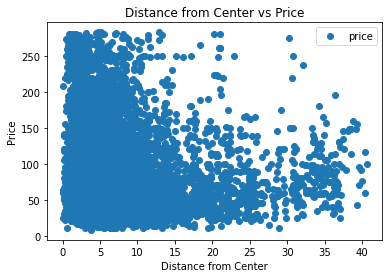

In [15]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.
df.plot(x = 'dist_from_center', y='price',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Distance from Center vs Price')  
plt.xlabel('Distance from Center')  
plt.ylabel('Price')  
plt.show()

In [16]:
# Reshape the variables into NumPy arrays and put them into separate objects.
X = df['dist_from_center'].values.reshape(-1,1)
y = df['price'].values.reshape(-1,1)

In [17]:
X

array([[2.33540984],
       [4.06167385],
       [7.13568788],
       ...,
       [6.75479844],
       [1.54308477],
       [2.90323532]])

In [18]:
y

array([[ 50],
       [ 43],
       [ 42],
       ...,
       [ 60],
       [ 36],
       [162]])

In [19]:
# Split data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 04. Define Hypothesis: 
    
### If the listing is closer to the center, price gets higher.

### 05. Regression analysis

In [20]:
# Create a regression object.

regression = LinearRegression()

In [21]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [22]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

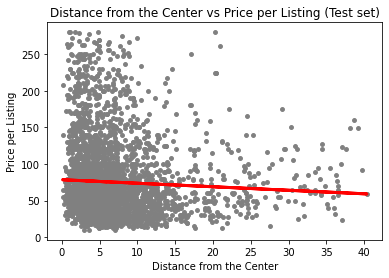

In [23]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Distance from the Center vs Price per Listing (Test set)')
plot_test.xlabel('Distance from the Center')
plot_test.ylabel('Price per Listing')
plot_test.show()

In [24]:
# Create objects that contain the model summary statistics.
rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [25]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[-0.48052455]]
Mean squared error:  2595.9660223566084
R2 score:  0.003377153323805837


In [26]:
y_predicted

array([[76.97655942],
       [76.09870816],
       [75.56161192],
       ...,
       [78.11234378],
       [77.09130281],
       [75.7756753 ]])

In [27]:
# Create a dataframe comparing the actual and predicted values of y.
data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(10)

,Actual,Predicted
0,140,76.976559
1,50,76.098708
2,70,75.561612
3,149,60.225614
4,66,76.280391
5,116,75.521583
6,90,78.302219
7,20,76.562565
8,144,77.923961
9,101,75.033842


##### Compare how the regression fits the training set

In [28]:
# Predict.
y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [29]:
mse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [30]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[-0.48052455]]
Mean squared error:  2595.9660223566084
R2 score:  0.0027170012389025056


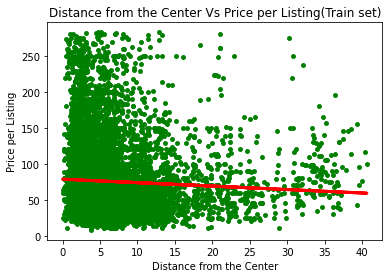

In [31]:
# Visualizing the training set results.

plot_train = plt
plot_train.scatter(X_train, y_train, color='green', s = 15)
plot_train.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_train.title('Distance from the Center Vs Price per Listing(Train set)')
plot_train.xlabel('Distance from the Center')
plot_train.ylabel('Price per Listing')
plot_train.show()

### 06. Results
When looking at the training and test sets, we see some similarities. However, overall, we can observe that the regression analysis indicates that there is not a good fit and a low level of negative correlation between the variables.

The slope here means that as X rises (as the distance froma center of berlin rises), y slightly drops (the price per unit drops). It shows there is a weak negative relationship between the variables.

However, there is significantly high mean squared errors of 2595 in the test and training regressions respectively. Moreover, the actual and predicted values vary greatly in size. As such, this high level of MSE means that the regression line is not very close to the observations, and therefore is clearly not a good fit. 

Lastly, we have very low R-squared values of 0.0033 and 0.0027 respectively. After looking at of these, it’s pretty clear that model isn’t performing well which highlights that these variables do not truly impact one another. 

### 07. Define New Hypothesis 
As the above model is not performing very well, lets explore other variables which may impact the price of the listings.

### If review_scores_cleanliness of the listing is higher, price gets higher.

In [32]:
# import data set required for hypothesis
listings = pd.read_csv(os.path.join(path, 'Original Data','airbnb_berlin', 'listings_2.csv'))

In [33]:
listings.shape

(16416, 74)

In [34]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,39971294,https://www.airbnb.com/rooms/39971294,20220613034419,2022-06-13,Cozy flat with chimney,NaN,NaN,https://a0.muscache.com/pictures/a10c1d51-2954...,21565256,https://www.airbnb.com/users/show/21565256,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.06
1,11934470,https://www.airbnb.com/rooms/11934470,20220613034419,2022-06-13,Bright Studio Apartment / 4th fl/ long term,Just renovedt Studio apartment a few steps fro...,NaN,https://a0.muscache.com/pictures/56a1ce3f-e2c6...,62819516,https://www.airbnb.com/users/show/62819516,...,4.80,4.60,4.20,NaN,t,2,2,0,0,0.07
2,17580693,https://www.airbnb.com/rooms/17580693,20220613034419,2022-06-13,"Gemütliches, Zentrales Zimmer mit Blick ins Grüne","Meine Unterkunft ist gut für paare, alleinreis...",NaN,https://a0.muscache.com/pictures/91db5cb4-ab79...,119416956,https://www.airbnb.com/users/show/119416956,...,4.84,4.71,4.68,NaN,f,1,0,1,0,0.50
3,579471587567149993,https://www.airbnb.com/rooms/579471587567149993,20220613034419,2022-06-13,Süßes Altbau-Apartment in Schöneberg,"Praktikum, berufliches Projekt oder Besuch bei...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,9916942,https://www.airbnb.com/users/show/9916942,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
4,17497917,https://www.airbnb.com/rooms/17497917,20220613034419,2022-06-13,BERLIN MITTE - hotspot - central & calm,"Sourrounded by shopping stores, coffees in the...",Food recommendation<br />You would find anythi...,https://a0.muscache.com/pictures/b0745feb-56d3...,5937313,https://www.airbnb.com/users/show/5937313,...,4.87,4.96,4.70,NaN,f,1,1,0,0,1.84


In [35]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [36]:
# joining only the required columns from the listings data 
df = pd.merge(df,listings[['id','review_scores_cleanliness']],on='id', how='left')

In [37]:
df.head()

,id,name,host_id,district,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,host_total_listings,availability_365,num_reviews_ltm,price_category,dist_from_center,review_scores_cleanliness
0,39971294,Cozy flat with chimney,21565256,Friedrichshain-Kreuzberg,nördliche Luisenstadt,52.50168,13.41573,Entire home/apt,50,1,2,2019-12-02,0.06,1,0,0,medium_price,2.335410,5.00
1,11934470,Bright Studio Apartment / 4th fl/ long term,62819516,Neukölln,Reuterstraße,52.49226,13.42937,Entire home/apt,43,30,5,2022-03-29,0.07,2,271,3,medium_price,4.061674,4.80
2,17580693,"Gemütliches, Zentrales Zimmer mit Blick ins Grüne",119416956,Mitte,Parkviertel,52.56151,13.35515,Private room,42,2,31,2022-03-07,0.50,1,10,4,medium_price,7.135688,4.58
3,17497917,BERLIN MITTE - hotspot - central & calm,5937313,Mitte,Alexanderplatz,52.52438,13.41012,Entire home/apt,106,2,116,2022-05-29,1.84,1,6,25,high_price,0.741165,4.95
4,9924899,"Charming room in Kreuzberg, Graefekiez",4289187,Friedrichshain-Kreuzberg,Tempelhofer Vorstadt,52.49087,13.41712,Private room,39,3,7,2019-09-20,0.09,2,0,0,medium_price,3.470585,4.86


In [38]:
df.shape

(12869, 19)

In [39]:
df['review_scores_cleanliness'].describe()

count    12608.000000
mean         4.638880
std          0.515466
min          0.000000
25%          4.500000
50%          4.800000
75%          5.000000
max          5.000000
Name: review_scores_cleanliness, dtype: float64

In [40]:
#  Clean the extreme values 0 from the "review_scores_cleanliness" variable observed above.
df = df[df['review_scores_cleanliness'] > 0] 

In [41]:
df.shape

(12600, 19)

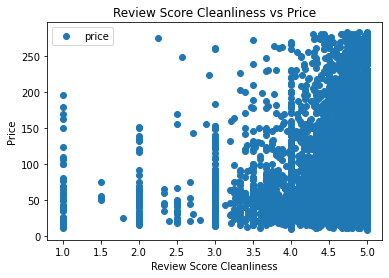

In [42]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.
df.plot(x = 'review_scores_cleanliness', y='price',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Review Score Cleanliness vs Price')  
plt.xlabel('Review Score Cleanliness')  
plt.ylabel('Price')  
plt.show()

In [43]:
# Reshape the variables into NumPy arrays and put them into separate objects.
X_2 = df['review_scores_cleanliness'].values.reshape(-1,1)
y_2 = df['price'].values.reshape(-1,1)

In [44]:
X_2

array([[5.  ],
       [4.8 ],
       [4.58],
       ...,
       [4.25],
       [4.75],
       [4.72]])

In [45]:
y_2

array([[ 50],
       [ 43],
       [ 42],
       ...,
       [ 60],
       [ 36],
       [162]])

In [46]:
# Split data into a training set and a test set.

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.3, random_state=0)

In [47]:
# Create a regression object.
regression = LinearRegression()  

# Fit the regression object onto the training set.
regression.fit(X_2_train, y_2_train)

LinearRegression()

In [48]:
# Predict the values of y using X.

y_2_predicted = regression.predict(X_2_test)

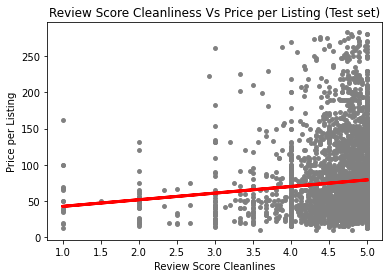

In [49]:
# Create a plot that shows the regression line from the model on the test set.

plot_test_2 = plt
plot_test_2.scatter(X_2_test, y_2_test, color='gray', s = 15)
plot_test_2.plot(X_2_test, y_2_predicted, color='red', linewidth =3)
plot_test_2.title('Review Score Cleanliness Vs Price per Listing (Test set)')
plot_test_2.xlabel('Review Score Cleanlines')
plot_test_2.ylabel('Price per Listing')
plot_test_2.show()

In [50]:
# Create objects that contain the model summary statistics.

rmse_2 = mean_squared_error(y_2_test, y_2_predicted) #  mean squared error
r2_2 = r2_score(y_2_test, y_2_predicted) #  R2 score. 

In [51]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse_2)
print('R2 score: ', r2_2)

Slope: [[9.1514739]]
Mean squared error:  2607.7389854943995
R2 score:  0.008743446960875811


In [52]:
y_2_predicted

array([[79.10598296],
       [79.10598296],
       [79.10598296],
       ...,
       [78.92295348],
       [79.10598296],
       [79.10598296]])

In [53]:
# Create a dataframe comparing the actual and predicted values of y.

data_2 = pd.DataFrame({'Actual': y_2_test.flatten(), 'Predicted': y_2_predicted.flatten()})
data_2.head(10)

,Actual,Predicted
0,80,79.105983
1,65,79.105983
2,37,79.105983
3,131,77.824777
4,120,79.105983
5,136,78.556895
6,50,79.105983
7,32,74.530246
8,89,78.831439
9,135,75.353879


##### Compare how the regression fits the training set

In [54]:
# Predict.

y_2_predicted_train = regression.predict(X_2_train) # This is predicting X_train!

In [55]:
rmse_2 = mean_squared_error(y_2_train, y_2_predicted_train)
r2_2 = r2_score(y_2_train, y_2_predicted_train)

In [56]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse_2)
print('R2 score: ', r2_2)

Slope: [[9.1514739]]
Mean squared error:  2669.010880189179
R2 score:  0.007484970877679853


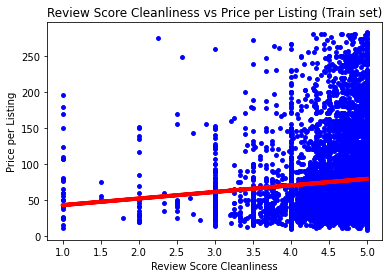

In [57]:
# Visualizing the training set results.

plot_train_2 = plt
plot_train_2.scatter(X_2_train, y_2_train, color='blue', s = 15)
plot_train_2.plot(X_2_train, y_2_predicted_train, color='red', linewidth =4)
plot_train_2.title('Review Score Cleanliness vs Price per Listing (Train set)')
plot_train_2.xlabel('Review Score Cleanliness')
plot_train_2.ylabel('Price per Listing')
plot_train_2.show()

### 08. New Results
When looking at the training and test sets, we see some similarities. However, overall, we can observe that the regression analysis indicates that there is not a good fit and a low level of positive correlation between the variables.

The +ve slope of 9 means that as X rises (as the review  secore for cleanliness rises), y slightly drops (the price per listing rises). It shows there is a weak positive relationship between the variables.

However, there is very high mean squared errors of 2607 & 2669 in the test and training regressions respectively. Moreover, the actual and predicted values vary greatly in size. As such, this high level of MSE means that the regression line is not very close to the observations, and therefore is clearly not a good fit. 

Lastly, we have very low R-squared values of 0.0087 and 0.0074 respectively. After looking at of these, it’s pretty clear that model isn’t performing well which highlights that these variables do not truly impact one another. 

Furthermore, it is likely that the price per night of a stay could be influenced by other factors such as room_type and/or neighborhood_group. As we have already seen in 6.3,there are few neighbourhood_groups where price of the listing are in higher side.

In [ ]:
df.to_csv(os.path.join(path,))